In [1]:
# Import necessary libraries
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import StringType, DoubleType
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from wordcloud import WordCloud
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Set chart style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("Libraries imported successfully!")


Libraries imported successfully!


In [2]:
# Initialize Spark Session and load cleaned data
spark = SparkSession.builder \
    .appName("TweetAnalysis_EDA_Sentiment") \
    .master("local[*]") \
    .config("spark.driver.memory", "16g") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

print(f"Spark Version: {spark.version}")

# Load cleaned data (based on output path from step 2)
cleaned_data_path = "/home/jovyan/work/data/processed/cleaned_comments.parquet"
print(f"Attempting to load data from: {cleaned_data_path}")

try:
    df_cleaned = spark.read.parquet(cleaned_data_path)
    df_cleaned.cache()
    record_count = df_cleaned.count()
    print(f"✅ Cleaned data loaded successfully, total {record_count:,} records")
    print("\nData structure:")
    df_cleaned.printSchema()
    
    # Display preview of first few rows
    print("\nData preview (first 3 rows):")
    df_cleaned.select("id", "`subreddit.name`", "cleaned_body", "sentiment").show(3, truncate=False)
    
except Exception as e:
    print(f"❌ Data loading failed: {e}")
    print("Please ensure you have completed the data cleaning notebook from step 2")
    # Create an empty DataFrame as fallback
    df_cleaned = None


Spark Version: 3.5.0
Attempting to load data from: /home/jovyan/work/data/processed/cleaned_comments.parquet
✅ Cleaned data loaded successfully, total 459,171 records

Data structure:
root
 |-- id: string (nullable = true)
 |-- subreddit.name: string (nullable = true)
 |-- created_utc: long (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- body: string (nullable = true)
 |-- cleaned_body: string (nullable = true)
 |-- tokens_cleaned: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- sentiment: double (nullable = true)
 |-- score: long (nullable = true)


Data preview (first 3 rows):
+-------+--------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [3]:
# Basic data overview and statistics
print("=== Basic Data Overview ===")

# Verify if data was loaded successfully
if df_cleaned is None:
    print("❌ Data not loaded, please run the previous cell and ensure data loads successfully")
else:
    # 1. Basic data information
    print("1. Basic data information:")
    print(f"Total records: {df_cleaned.count():,}")
    print(f"Total columns: {len(df_cleaned.columns)}")

    # 2. Data completeness check for each column
    print("\n2. Data completeness:")
    for col_name in df_cleaned.columns:
        # Handle column names containing dots
        if "." in col_name:
            null_count = df_cleaned.filter(F.col(f"`{col_name}`").isNull()).count()
        else:
            null_count = df_cleaned.filter(F.col(col_name).isNull()).count()
        total_count = df_cleaned.count()
        print(f"  {col_name}: {((total_count - null_count) / total_count * 100):.1f}% complete")

    # 3. Sentiment score statistics
    print("\n3. Sentiment score distribution:")
    sentiment_stats = df_cleaned.select("sentiment").describe()
    sentiment_stats.show()

    # 4. Subreddit distribution
    print("4. Subreddit distribution (Top 10):")
    subreddit_dist = df_cleaned.groupBy("`subreddit.name`").count().orderBy(F.desc("count")).limit(10)
    subreddit_dist.show(truncate=False)


=== Basic Data Overview ===
1. Basic data information:
Total records: 459,171
Total columns: 9

2. Data completeness:
  id: 100.0% complete
  subreddit.name: 100.0% complete
  created_utc: 100.0% complete
  timestamp: 100.0% complete
  body: 100.0% complete
  cleaned_body: 100.0% complete
  tokens_cleaned: 100.0% complete
  sentiment: 98.9% complete
  score: 100.0% complete

3. Sentiment score distribution:
+-------+--------------------+
|summary|           sentiment|
+-------+--------------------+
|  count|              454264|
|   mean|-0.00644086346265...|
| stddev|  0.6588389261269937|
|    min|             -0.9999|
|    max|              0.9999|
+-------+--------------------+

4. Subreddit distribution (Top 10):
+--------------+-----+
|subreddit.name|count|
+--------------+-----+
|politics      |36989|
|worldnews     |35283|
|askreddit     |25863|
|news          |9524 |
|collapse      |9490 |
|futurology    |8904 |
|science       |7063 |
|environment   |6819 |
|canada        |6722

In [4]:
# Re-analyze sentiment using VADER (improve original sentiment scores)
print("=== VADER Sentiment Analysis ===")

# Verify if data is available
if df_cleaned is None:
    print("❌ Data not loaded, please run previous cells and ensure data loads successfully")
else:
    # Create VADER sentiment analyzer
    analyzer = SentimentIntensityAnalyzer()

    def analyze_sentiment_vader(text):
        """Perform sentiment analysis using VADER"""
        if text is None:
            return None
        scores = analyzer.polarity_scores(str(text))
        return scores['compound']  # Return compound sentiment score (-1 to 1)

    # Create UDF for Spark
    sentiment_udf = F.udf(analyze_sentiment_vader, DoubleType())

    # Apply VADER sentiment analysis to cleaned text
    print("Applying VADER sentiment analysis...")
    df_with_vader = df_cleaned.withColumn("vader_sentiment", sentiment_udf(F.col("cleaned_body")))

    # Cache results
    df_with_vader.cache()

    print("VADER sentiment analysis completed!")

    # Compare original sentiment scores vs VADER scores
    print("\nOriginal sentiment score vs VADER score comparison:")
    comparison = df_with_vader.select("sentiment", "vader_sentiment").filter(
        F.col("sentiment").isNotNull() & F.col("vader_sentiment").isNotNull()
    ).limit(10)
    comparison.show()

    # VADER sentiment score statistics
    print("\nVADER sentiment score statistics:")
    vader_stats = df_with_vader.select("vader_sentiment").describe()
    vader_stats.show()


=== VADER Sentiment Analysis ===
Applying VADER sentiment analysis...
VADER sentiment analysis completed!

Original sentiment score vs VADER score comparison:
+---------+---------------+
|sentiment|vader_sentiment|
+---------+---------------+
|   0.5106|         0.5106|
|      0.0|            0.0|
|   0.7269|         0.7269|
|   0.6021|         0.6021|
|  -0.9824|         -0.992|
|   0.8948|         0.8948|
|  -0.8556|        -0.6997|
|    -0.25|          -0.25|
|    0.398|         0.7949|
|  -0.9118|        -0.9118|
+---------+---------------+


VADER sentiment score statistics:
+-------+--------------------+
|summary|     vader_sentiment|
+-------+--------------------+
|  count|              459171|
|   mean|0.007410569482828808|
| stddev|  0.6618577281362763|
|    min|             -0.9999|
|    max|              0.9999|
+-------+--------------------+



=== Sentiment Distribution Analysis ===
Preparing visualization data...

Sentiment distribution:
  sentiment_category   count
0           Positive  211657
1            Neutral   38668
2           Negative  208846


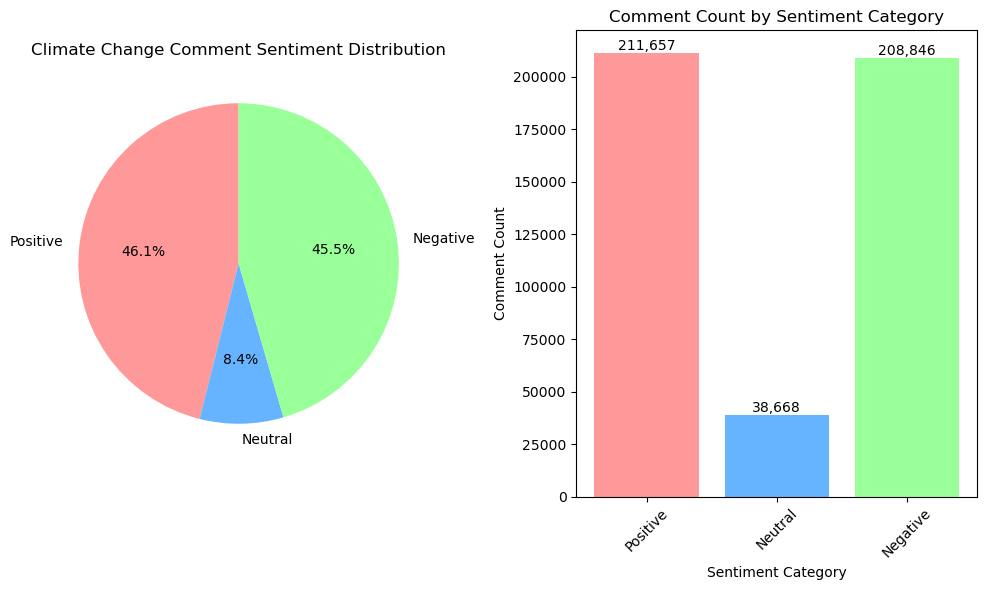

Sentiment distribution visualization completed!


In [5]:
# Sentiment distribution analysis and visualization
print("=== Sentiment Distribution Analysis ===")

# Verify if VADER analysis is completed
try:
    df_with_vader
    print("Preparing visualization data...")
    
    # Create sentiment classification
    def categorize_sentiment(score):
        if score is None:
            return "Unknown"
        elif score > 0.05:
            return "Positive"
        elif score < -0.05:
            return "Negative"
        else:
            return "Neutral"

    categorize_udf = F.udf(categorize_sentiment, StringType())

    # Apply sentiment classification
    df_categorized = df_with_vader.withColumn("sentiment_category", categorize_udf(F.col("vader_sentiment")))

    # Convert to Pandas for analysis
    sentiment_dist = df_categorized.groupBy("sentiment_category").count().toPandas()
    print("\nSentiment distribution:")
    print(sentiment_dist)

    # Plot sentiment distribution pie chart
    plt.figure(figsize=(10, 6))

    # Pie chart
    plt.subplot(1, 2, 1)
    colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
    plt.pie(sentiment_dist['count'], labels=sentiment_dist['sentiment_category'], 
            autopct='%1.1f%%', colors=colors, startangle=90)
    plt.title('Climate Change Comment Sentiment Distribution')

    # Bar chart
    plt.subplot(1, 2, 2)
    bars = plt.bar(sentiment_dist['sentiment_category'], sentiment_dist['count'], color=colors)
    plt.title('Comment Count by Sentiment Category')
    plt.xlabel('Sentiment Category')
    plt.ylabel('Comment Count')
    plt.xticks(rotation=45)

    # Add value labels on bar chart
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{int(height):,}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    print("Sentiment distribution visualization completed!")
    
except NameError:
    print("❌ VADER sentiment analysis not completed, please run previous cells")


=== Subreddit Sentiment Analysis ===
Main subreddit sentiment analysis results:
  subreddit.name  comment_count  avg_sentiment  positive_count  \
0       politics          36989      -0.001880           17038   
1      worldnews          35283      -0.042786           15327   
2      askreddit          25863      -0.064260            9483   
3           news           9524      -0.077059            3875   
4       collapse           9490      -0.113639            3813   
5     futurology           8904       0.018289            4188   
6        science           7063       0.064287            3535   
7    environment           6819       0.001119            3130   
8         canada           6722       0.048966            3293   
9      australia           5993      -0.011873            2720   

   negative_count  neutral_count  
0           17318           2633  
1           17300           2656  
2           11952           4428  
3            4820            829  
4            5053 

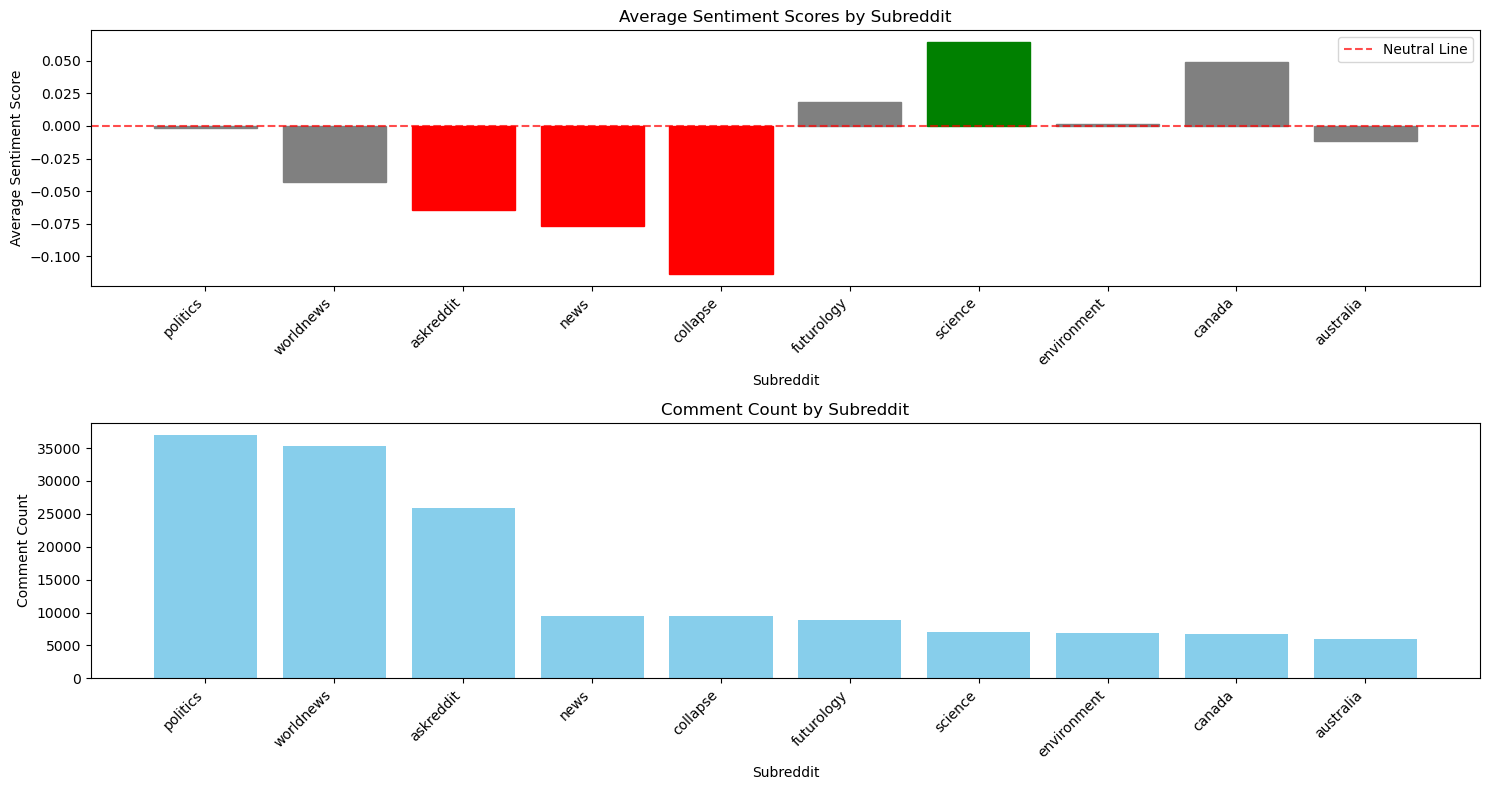

Subreddit sentiment analysis visualization completed!


In [6]:
# Subreddit sentiment analysis
print("=== Subreddit Sentiment Analysis ===")

# Verify if sentiment classification data is available
try:
    df_categorized
    
    # Calculate average sentiment scores for each subreddit
    subreddit_sentiment = df_categorized.groupBy("`subreddit.name`").agg(
        F.count("*").alias("comment_count"),
        F.avg("vader_sentiment").alias("avg_sentiment"),
        F.sum(F.when(F.col("sentiment_category") == "Positive", 1).otherwise(0)).alias("positive_count"),
        F.sum(F.when(F.col("sentiment_category") == "Negative", 1).otherwise(0)).alias("negative_count"),
        F.sum(F.when(F.col("sentiment_category") == "Neutral", 1).otherwise(0)).alias("neutral_count")
    ).filter(F.col("comment_count") >= 1000).orderBy(F.desc("comment_count"))

    # Convert to Pandas and display
    subreddit_sentiment_pd = subreddit_sentiment.toPandas()
    print("Main subreddit sentiment analysis results:")
    print(subreddit_sentiment_pd.head(10))

    # Plot subreddit sentiment comparison chart
    plt.figure(figsize=(15, 8))

    # Select top 10 most active subreddits
    top_subreddits = subreddit_sentiment_pd.head(10)

    # Subreddit average sentiment scores
    plt.subplot(2, 1, 1)
    bars = plt.bar(range(len(top_subreddits)), top_subreddits['avg_sentiment'])
    plt.title('Average Sentiment Scores by Subreddit')
    plt.xlabel('Subreddit')
    plt.ylabel('Average Sentiment Score')
    plt.xticks(range(len(top_subreddits)), top_subreddits['subreddit.name'], rotation=45, ha='right')
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.7, label='Neutral Line')
    plt.legend()

    # Add colors to bars (green for positive, red for negative, gray for neutral)
    for i, bar in enumerate(bars):
        if top_subreddits.iloc[i]['avg_sentiment'] > 0.05:
            bar.set_color('green')
        elif top_subreddits.iloc[i]['avg_sentiment'] < -0.05:
            bar.set_color('red')
        else:
            bar.set_color('gray')

    # Subreddit comment counts
    plt.subplot(2, 1, 2)
    plt.bar(range(len(top_subreddits)), top_subreddits['comment_count'], color='skyblue')
    plt.title('Comment Count by Subreddit')
    plt.xlabel('Subreddit')
    plt.ylabel('Comment Count')
    plt.xticks(range(len(top_subreddits)), top_subreddits['subreddit.name'], rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

    print("Subreddit sentiment analysis visualization completed!")
    
except NameError:
    print("❌ Sentiment classification data not ready, please run previous cells first")


=== Time Series Sentiment Analysis ===
Annual sentiment trend analysis:
    year  total_comments  avg_sentiment  positive_count  negative_count  \
0   2010            1595       0.044215             791             692   
1   2011            2657       0.077628            1362            1097   
2   2012            4038       0.075008            2081            1689   
3   2013            6512       0.044751            3197            2889   
4   2014           11308       0.023823            5334            5080   
5   2015           16822       0.016500            7896            7626   
6   2016           31363       0.019203           14815           14141   
7   2017           37708       0.025033           17827           16817   
8   2018           38714      -0.001614           17768           17808   
9   2019           98076      -0.014628           43465           45770   
10  2020           70049       0.008886           32390           31971   
11  2021           81871    

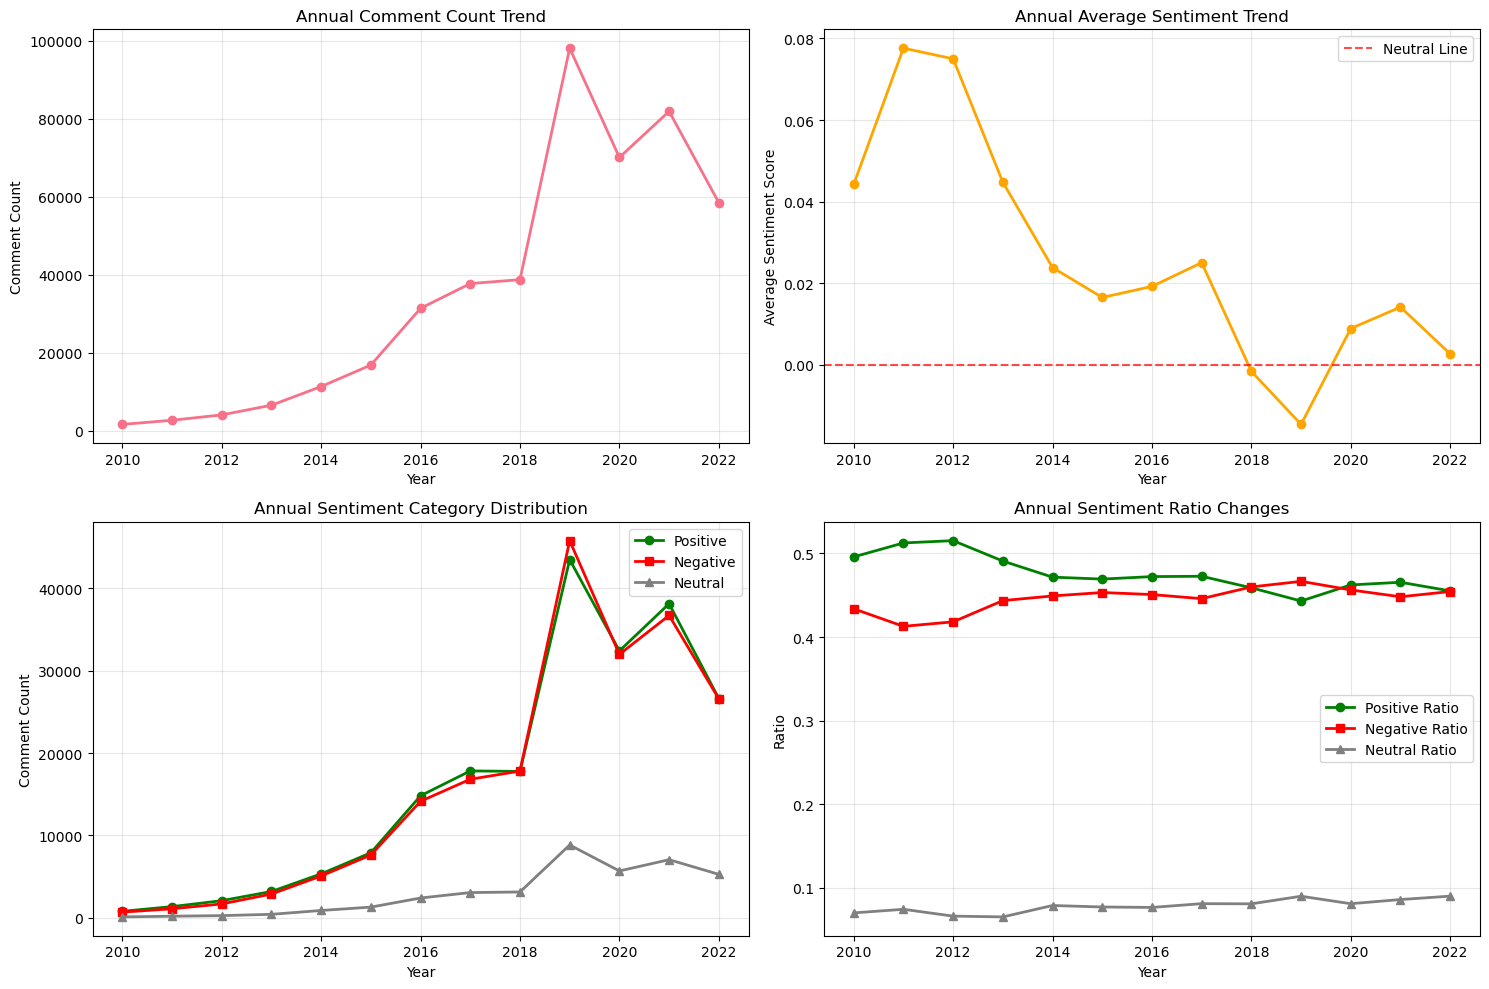

Time series sentiment analysis completed!


In [7]:
# Time series sentiment analysis
print("=== Time Series Sentiment Analysis ===")

# Verify if sentiment classification data is available
try:
    df_categorized
    
    # Extract year from timestamp
    df_with_year = df_categorized.withColumn("year", F.year(F.col("timestamp")))
    
    # Analyze sentiment trends by year
    yearly_sentiment = df_with_year.groupBy("year").agg(
        F.count("*").alias("total_comments"),
        F.avg("vader_sentiment").alias("avg_sentiment"),
        F.sum(F.when(F.col("sentiment_category") == "Positive", 1).otherwise(0)).alias("positive_count"),
        F.sum(F.when(F.col("sentiment_category") == "Negative", 1).otherwise(0)).alias("negative_count"),
        F.sum(F.when(F.col("sentiment_category") == "Neutral", 1).otherwise(0)).alias("neutral_count")
    ).orderBy("year")
    
    # Convert to Pandas for visualization
    yearly_sentiment_pd = yearly_sentiment.toPandas()
    print("Annual sentiment trend analysis:")
    print(yearly_sentiment_pd)
    
    # Plot time series charts
    plt.figure(figsize=(15, 10))
    
    # Annual comment count trend
    plt.subplot(2, 2, 1)
    plt.plot(yearly_sentiment_pd['year'], yearly_sentiment_pd['total_comments'], marker='o', linewidth=2)
    plt.title('Annual Comment Count Trend')
    plt.xlabel('Year')
    plt.ylabel('Comment Count')
    plt.grid(True, alpha=0.3)
    
    # Annual average sentiment trend
    plt.subplot(2, 2, 2)
    plt.plot(yearly_sentiment_pd['year'], yearly_sentiment_pd['avg_sentiment'], 
             marker='o', linewidth=2, color='orange')
    plt.title('Annual Average Sentiment Trend')
    plt.xlabel('Year')
    plt.ylabel('Average Sentiment Score')
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.7, label='Neutral Line')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Annual sentiment category distribution
    plt.subplot(2, 2, 3)
    plt.plot(yearly_sentiment_pd['year'], yearly_sentiment_pd['positive_count'], 
             marker='o', label='Positive', color='green', linewidth=2)
    plt.plot(yearly_sentiment_pd['year'], yearly_sentiment_pd['negative_count'], 
             marker='s', label='Negative', color='red', linewidth=2)
    plt.plot(yearly_sentiment_pd['year'], yearly_sentiment_pd['neutral_count'], 
             marker='^', label='Neutral', color='gray', linewidth=2)
    plt.title('Annual Sentiment Category Distribution')
    plt.xlabel('Year')
    plt.ylabel('Comment Count')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Annual sentiment ratio changes
    plt.subplot(2, 2, 4)
    yearly_sentiment_pd['positive_ratio'] = yearly_sentiment_pd['positive_count'] / yearly_sentiment_pd['total_comments']
    yearly_sentiment_pd['negative_ratio'] = yearly_sentiment_pd['negative_count'] / yearly_sentiment_pd['total_comments']
    yearly_sentiment_pd['neutral_ratio'] = yearly_sentiment_pd['neutral_count'] / yearly_sentiment_pd['total_comments']
    
    plt.plot(yearly_sentiment_pd['year'], yearly_sentiment_pd['positive_ratio'], 
             marker='o', label='Positive Ratio', color='green', linewidth=2)
    plt.plot(yearly_sentiment_pd['year'], yearly_sentiment_pd['negative_ratio'], 
             marker='s', label='Negative Ratio', color='red', linewidth=2)
    plt.plot(yearly_sentiment_pd['year'], yearly_sentiment_pd['neutral_ratio'], 
             marker='^', label='Neutral Ratio', color='gray', linewidth=2)
    plt.title('Annual Sentiment Ratio Changes')
    plt.xlabel('Year')
    plt.ylabel('Ratio')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("Time series sentiment analysis completed!")
    
except NameError:
    print("❌ Sentiment classification data not ready, please run previous cells first")


=== Word Frequency Analysis and Word Cloud Generation ===
Analyzing word frequency...
Top 20 high-frequency words:
      token   count
0   climate  606389
1    change  409329
2    people  229781
3      like  173685
4        re  125493
5     think  122634
6       one  115179
7      even  112339
8         .  101838
9         m   98188
10      get   94738
11  change.   93347
12     also   87322
13    going   81535
14       us   80472
15     much   80098
16     make   77048
17    world   73923
18     need   68267
19     know   68190

Analyzing word frequency for different sentiment categories...
Generating word clouds...


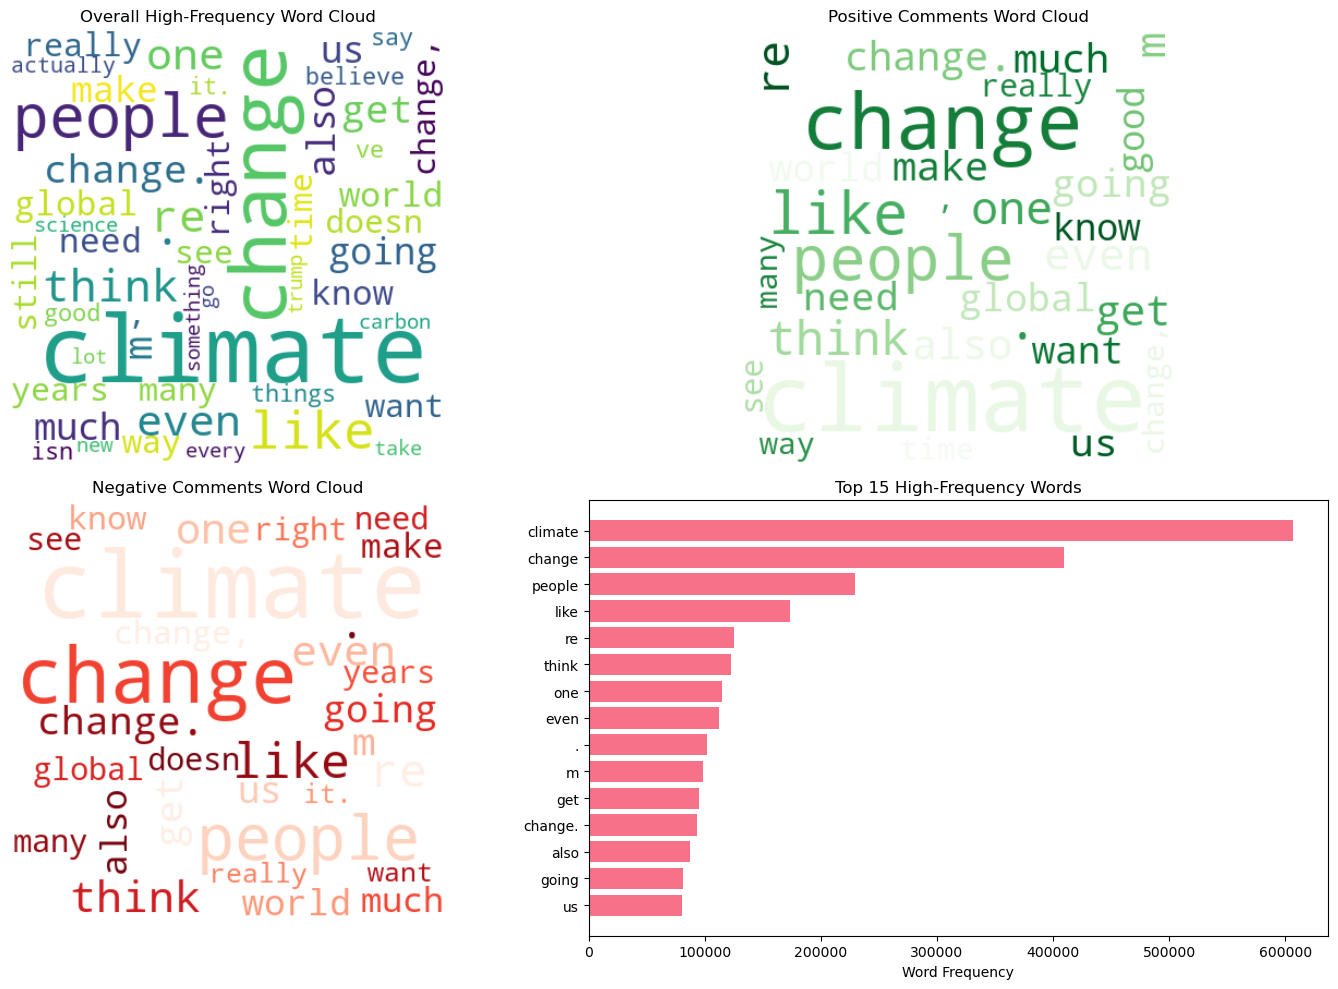

Word frequency analysis and word cloud generation completed!


In [8]:
# Word frequency analysis and word cloud generation
print("=== Word Frequency Analysis and Word Cloud Generation ===")

# Verify if classification data is available
try:
    df_categorized
    
    # Extract all words from tokens_cleaned
    print("Analyzing word frequency...")

    # Explode all tokens and calculate frequency
    all_tokens = df_categorized.select(F.explode(F.col("tokens_cleaned")).alias("token"))
    word_freq = all_tokens.groupBy("token").count().orderBy(F.desc("count"))

    # Get top 50 high-frequency words
    top_words = word_freq.limit(50).toPandas()
    print("Top 20 high-frequency words:")
    print(top_words.head(20))

    # Analyze word frequency for different sentiment categories separately
    print("\nAnalyzing word frequency for different sentiment categories...")

    # Word frequency for positive comments
    positive_tokens = df_categorized.filter(F.col("sentiment_category") == "Positive").select(
        F.explode(F.col("tokens_cleaned")).alias("token")
    )
    positive_word_freq = positive_tokens.groupBy("token").count().orderBy(F.desc("count")).limit(30).toPandas()

    # Word frequency for negative comments
    negative_tokens = df_categorized.filter(F.col("sentiment_category") == "Negative").select(
        F.explode(F.col("tokens_cleaned")).alias("token")
    )
    negative_word_freq = negative_tokens.groupBy("token").count().orderBy(F.desc("count")).limit(30).toPandas()

    # Generate word clouds
    print("Generating word clouds...")

    # Prepare word cloud data
    word_freq_dict = dict(zip(top_words['token'], top_words['count']))

    # Generate overall word cloud
    plt.figure(figsize=(15, 10))

    # Overall word cloud
    plt.subplot(2, 2, 1)
    wordcloud = WordCloud(width=400, height=400, background_color='white', 
                         max_words=100, colormap='viridis').generate_from_frequencies(word_freq_dict)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Overall High-Frequency Word Cloud')
    plt.axis('off')

    # Positive comments word cloud
    plt.subplot(2, 2, 2)
    positive_dict = dict(zip(positive_word_freq['token'], positive_word_freq['count']))
    positive_wordcloud = WordCloud(width=400, height=400, background_color='white',
                                  max_words=50, colormap='Greens').generate_from_frequencies(positive_dict)
    plt.imshow(positive_wordcloud, interpolation='bilinear')
    plt.title('Positive Comments Word Cloud')
    plt.axis('off')

    # Negative comments word cloud
    plt.subplot(2, 2, 3)
    negative_dict = dict(zip(negative_word_freq['token'], negative_word_freq['count']))
    negative_wordcloud = WordCloud(width=400, height=400, background_color='white',
                                  max_words=50, colormap='Reds').generate_from_frequencies(negative_dict)
    plt.imshow(negative_wordcloud, interpolation='bilinear')
    plt.title('Negative Comments Word Cloud')
    plt.axis('off')

    # Word frequency comparison chart
    plt.subplot(2, 2, 4)
    top_15_words = top_words.head(15)
    plt.barh(range(len(top_15_words)), top_15_words['count'])
    plt.yticks(range(len(top_15_words)), top_15_words['token'])
    plt.xlabel('Word Frequency')
    plt.title('Top 15 High-Frequency Words')
    plt.gca().invert_yaxis()

    plt.tight_layout()
    plt.show()
    
    print("Word frequency analysis and word cloud generation completed!")
    
except NameError:
    print("❌ Classification data not ready, please run previous cells")


In [9]:
# Analysis summary and save results
print("=== Exploratory Data Analysis Summary ===")

# Verify if all necessary data is available
try:
    df_categorized
    subreddit_sentiment_pd
    yearly_sentiment_pd

    # Generate analysis report
    total_comments = df_categorized.count()
    sentiment_dist_final = df_categorized.groupBy("sentiment_category").count().toPandas()

    print("📊 **Data Overview**:")
    print(f"   Total comments: {total_comments:,}")
    print(f"   Analysis time span: 2010-2022")
    print(f"   Main subreddits: politics, worldnews, askreddit")

    print("\n🎭 **Sentiment Distribution**:")
    for _, row in sentiment_dist_final.iterrows():
        percentage = (row['count'] / total_comments) * 100
        print(f"   {row['sentiment_category']}: {row['count']:,} ({percentage:.1f}%)")

    print("\n📈 **Key Findings**:")
    yearly_summary = yearly_sentiment_pd
    if len(yearly_summary) > 0:
        print(f"   Most negative year: {yearly_summary.loc[yearly_summary['avg_sentiment'].idxmin(), 'year']}")
        print(f"   Most positive year: {yearly_summary.loc[yearly_summary['avg_sentiment'].idxmax(), 'year']}")
        print(f"   Year with most comments: {yearly_summary.loc[yearly_summary['total_comments'].idxmax(), 'year']}")

    print("\n🏷️ **Subreddit Characteristics**:")
    if len(subreddit_sentiment_pd) > 0:
        most_positive = subreddit_sentiment_pd.loc[subreddit_sentiment_pd['avg_sentiment'].idxmax()]
        most_negative = subreddit_sentiment_pd.loc[subreddit_sentiment_pd['avg_sentiment'].idxmin()]
        print(f"   Most positive subreddit: {most_positive['subreddit.name']} (score: {most_positive['avg_sentiment']:.3f})")
        print(f"   Most negative subreddit: {most_negative['subreddit.name']} (score: {most_negative['avg_sentiment']:.3f})")

    print("\n💾 **Saving Enhanced Data**:")
    output_path = "/home/jovyan/work/data/processed/sentiment_analyzed_comments.parquet"
    print(f"Saving to: {output_path}")

    try:
        df_categorized.select(
            "id", "`subreddit.name`", "created_utc", "timestamp",
            "body", "cleaned_body", "tokens_cleaned", "sentiment",
            "vader_sentiment", "sentiment_category", "score"
        ).write.mode("overwrite").parquet(output_path)
        print("✅ Sentiment analysis results saved successfully!")
    except Exception as e:
        print(f"❌ Save failed: {e}")

    print("\n🎯 **Next Steps Recommendations**:")
    print("   1. Perform topic modeling (LDA) based on sentiment analysis results")
    print("   2. Train machine learning classification models")
    print("   3. Analyze impact of specific events on sentiment")
    print("   4. Build sentiment prediction models")

    print("\n✅ Exploratory data analysis and sentiment analysis completed!")

except NameError:
    print("❌ Analysis data not ready, please run all previous cells first")


=== Exploratory Data Analysis Summary ===
📊 **Data Overview**:
   Total comments: 459,171
   Analysis time span: 2010-2022
   Main subreddits: politics, worldnews, askreddit

🎭 **Sentiment Distribution**:
   Positive: 211,657 (46.1%)
   Neutral: 38,668 (8.4%)
   Negative: 208,846 (45.5%)

📈 **Key Findings**:
   Most negative year: 2019
   Most positive year: 2011
   Year with most comments: 2019

🏷️ **Subreddit Characteristics**:
   Most positive subreddit: bottown2 (score: 0.229)
   Most negative subreddit: publicfreakout (score: -0.211)

💾 **Saving Enhanced Data**:
Saving to: /home/jovyan/work/data/processed/sentiment_analyzed_comments.parquet
✅ Sentiment analysis results saved successfully!

🎯 **Next Steps Recommendations**:
   1. Perform topic modeling (LDA) based on sentiment analysis results
   2. Train machine learning classification models
   3. Analyze impact of specific events on sentiment
   4. Build sentiment prediction models

✅ Exploratory data analysis and sentiment anal

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 54222)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/opt/conda/lib/python3.11/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/opt/conda/lib/python3.11/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/opt/conda/lib/python3.11/socketserver.py", line 755, in __init__
    self.handle()
  File "/usr/local/spark/python/pyspark/accumulators.py", line 295, in handle
    poll(accum_updates)
  File "/usr/local/spark/python/pyspark/accumulators.py", line 267, in poll
    if self.rfile in r and func():
                           ^^^^^^
  File "/usr/local/spark/python/pyspark/accumulators.py", line 271, in accum_updates
    num_updates =